In [42]:
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer
import numpy as np
from sklearn.metrics.cluster import silhouette_score #evaluates how good clustering is
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold, cross_val_score
from sklearn import metrics
import scipy.stats as stats

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.preprocessing import StandardScaler


#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus


In [2]:
#Load Data
restdata = pd.read_csv('Restaurant_Inspections.csv')

In [3]:
restdatacleaned = restdata.copy()
#Replace spaces with _ in column names
restdatacleaned.columns = restdata.columns.map(lambda x: x.replace(" ","_"))

#clean up column names by lowercasing them
restdatacleaned.columns = restdatacleaned.columns.str.lower()

In [4]:
restdatacleaned.head()

,camis,dba,boro,building,street,zipcode,phone,cuisine_description,inspection_date,action,violation_code,violation_description,critical_flag,score,grade,grade_date,record_date,inspection_type
0,40393378,E.J LUNCHEONETTE,MANHATTAN,1271,THIRD AVENUE,10021,2124720600,American,07/12/2016,Violations were cited in the following area(s).,02G,Cold food item held above 41Âº F (smoked fish ...,Critical,31.0,NaN,NaN,04/22/2017,Cycle Inspection / Initial Inspection
1,41030615,SERAFINA,MANHATTAN,210,WEST 55 STREET,10019,2123151700,Italian,03/18/2016,Violations were cited in the following area(s).,09C,Food contact surface not properly maintained.,Not Critical,4.0,A,03/18/2016,04/22/2017,Cycle Inspection / Initial Inspection
2,40871795,WONDEE SIAM II,MANHATTAN,813,9 AVENUE,10019,9172861726,Thai,12/23/2015,Violations were cited in the following area(s).,02B,Hot food item not held at or above 140Âº F.,Critical,29.0,NaN,NaN,04/22/2017,Cycle Inspection / Initial Inspection
3,40750612,STROKOS PIZZA DELI,MANHATTAN,888,10 AVENUE,10019,2125816262,American,09/20/2016,Violations were cited in the following area(s).,10B,Plumbing not properly installed or maintained;...,Not Critical,13.0,A,09/20/2016,04/22/2017,Cycle Inspection / Initial Inspection
4,50036944,AMBER,MANHATTAN,103,W 70TH ST,10023,2127998100,Asian,11/12/2015,Violations were cited in the following area(s).,09B,Thawing procedures improper.,Not Critical,9.0,A,11/12/2015,04/22/2017,Pre-permit (Operational) / Re-inspection


In [5]:
#Investigate Data types
restdatacleaned.dtypes

camis                      int64
dba                       object
boro                      object
building                  object
street                    object
zipcode                    int64
phone                     object
cuisine_description       object
inspection_date           object
action                    object
violation_code            object
violation_description     object
critical_flag             object
score                    float64
grade                     object
grade_date                object
record_date               object
inspection_type           object
dtype: object

In [6]:
#Drop columns that don't add to analysis
restdatacleaned = restdatacleaned.drop(['camis','dba','inspection_date','building','street','phone','zipcode','action','violation_description','grade_date','record_date','inspection_type','grade'], axis=1)

In [7]:
#Drop all na values
restdatacleaned = restdatacleaned.dropna()

print "the original dataset size:", restdata.shape
print "after we dropped na values:", restdatacleaned.shape

#Calculate % of dataset lost
print "Percent of dataset retained after droping na", 25526.0/27251

the original dataset size: (27251, 18)
after we dropped na values: (25526, 5)
Percent of dataset retained after droping na 0.936699570658


In [8]:
#convert score column to integer
restdatacleaned.score = restdatacleaned.score.astype(int)

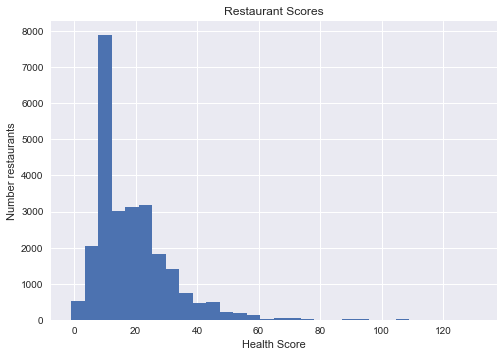

In [9]:
#Examine distribution of health scores
restdatacleaned.score.hist(bins=30)
sns.plt.title("Restaurant Scores")
sns.plt.ylabel("Number restaurants")
sns.plt.xlabel("Health Score")



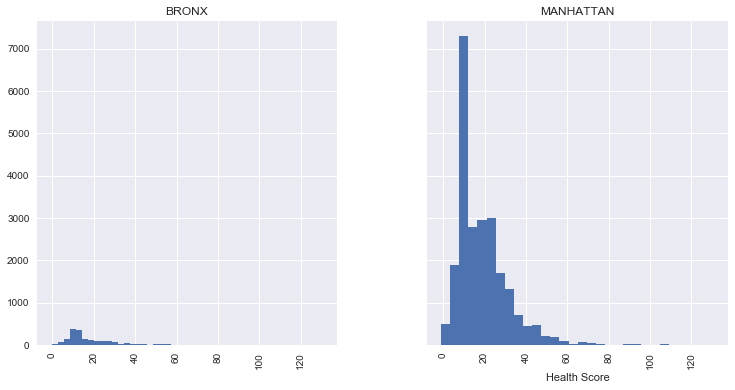

In [10]:
#Examine distribution by boro
#Notice that Bronx and Manhattan are only boroughs represented in this dataset

restdatacleaned.score.hist(by=restdatacleaned["boro"],bins=30,layout= (1,2),figsize=(12,6),sharex=True,sharey=True)
sns.plt.ylabel("Number restaurants")
sns.plt.xlabel("Health Score")

In [11]:
#Create score bins
bins = [0,10,20,30,40,50,60,restdatacleaned.score.max()+1]
restdatacleaned["score_bins"] = pd.cut(restdatacleaned['score'],bins)
restdatacleaned.score_bins.value_counts()

(10, 20]     10415
(0, 10]       6174
(20, 30]      5346
(30, 40]      2051
(40, 50]       927
(50, 60]       335
(60, 132]      265
Name: score_bins, dtype: int64

In [12]:
#Replace stange formatting for cafe
restdatacleaned.cuisine_description.replace(regex=True,inplace=True,to_replace='CafÃ©/Coffee/Tea',value='Cafe, Coffee, Tea')
restdatacleaned.cuisine_description.value_counts()

#There are 62 different cuisines. To simplify dataset, we are going to examine the cuisines that make up 80% of the dataset
#Top 17
restdatacuisinefilter = restdatacleaned.cuisine_description.value_counts(dropna=False)[1:18].index.values.tolist()

restdatafilter = restdatacleaned[restdatacleaned['cuisine_description'].isin(restdatacuisinefilter)]
restdatafilter.cuisine_description.value_counts()

Italian                                                             1976
Chinese                                                             1478
Japanese                                                            1422
Cafe, Coffee, Tea                                                   1209
Pizza                                                                959
Mexican                                                              882
French                                                               769
Indian                                                               740
Latin (Cuban, Dominican, Puerto Rican, South & Central American)     552
Thai                                                                 547
Delicatessen                                                         484
Pizza/Italian                                                        463
Asian                                                                421
Bakery                                             

In [13]:
print "the filtered dataset size is", 
restdatafilter.shape

the filtered dataset size is

(13424, 6)

In [14]:
#Convert violation  code to 0 / 1
violation_dummies = pd.get_dummies(restdatafilter.violation_code).astype(int)
violation_dummies.head()

restdatafilter = pd.concat([restdatafilter,violation_dummies],axis=1)
restdatafilter.drop("violation_code",inplace=True,axis=1)
restdatafilter.head()

,boro,cuisine_description,critical_flag,score,score_bins,02A,02B,02C,02D,02G,...,10C,10D,10E,10F,10G,10H,10I,10J,16B,22F
1,MANHATTAN,Italian,Not Critical,4,"(0, 10]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,MANHATTAN,Thai,Critical,29,"(20, 30]",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,MANHATTAN,Asian,Not Critical,9,"(0, 10]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,MANHATTAN,Thai,Not Critical,22,"(20, 30]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,MANHATTAN,Japanese,Not Critical,32,"(30, 40]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
#Convert critical flag to score
criticalflag_dummies = pd.get_dummies(restdatafilter.critical_flag).astype(int)
criticalflag_dummies.head()

restdatafilter = pd.concat([restdatafilter,criticalflag_dummies],axis=1)
restdatafilter.drop("critical_flag",inplace=True,axis=1)
restdatafilter.head()

,boro,cuisine_description,score,score_bins,02A,02B,02C,02D,02G,02H,...,10F,10G,10H,10I,10J,16B,22F,Critical,Not Applicable,Not Critical
1,MANHATTAN,Italian,4,"(0, 10]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,MANHATTAN,Thai,29,"(20, 30]",0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,MANHATTAN,Asian,9,"(0, 10]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,MANHATTAN,Thai,22,"(20, 30]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,MANHATTAN,Japanese,32,"(30, 40]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
#get_dummies for cuisine

cuisinedummies = pd.get_dummies(restdatafilter.cuisine_description).astype(int)
cuisinedummies.head()

restdatafilter = pd.concat([restdatafilter,cuisinedummies],axis=1)
restdatafilter.drop("cuisine_description",inplace=True,axis=1)
restdatafilter.head()

,boro,score,score_bins,02A,02B,02C,02D,02G,02H,02I,...,Irish,Italian,Japanese,Jewish/Kosher,"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",Mediterranean,Mexican,Pizza,Pizza/Italian,Thai
1,MANHATTAN,4,"(0, 10]",0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,MANHATTAN,29,"(20, 30]",0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,MANHATTAN,9,"(0, 10]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,MANHATTAN,22,"(20, 30]",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8,MANHATTAN,32,"(30, 40]",0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [17]:
#Get dummies for boro

borodummies = pd.get_dummies(restdatafilter.boro).astype(int)

restdatafilter = pd.concat([restdatafilter,borodummies],axis=1)
restdatafilter.drop("boro",inplace=True,axis=1)

In [18]:
restdatafilter.dtypes

score                                                                  int64
score_bins                                                          category
02A                                                                    int64
02B                                                                    int64
02C                                                                    int64
02D                                                                    int64
02G                                                                    int64
02H                                                                    int64
02I                                                                    int64
03A                                                                    int64
03B                                                                    int64
03C                                                                    int64
03D                                                                    int64

In [19]:
#Move score to last column and group feature columns

restdata_cols = restdatafilter.columns.tolist()

restdata_cols[3:]+restdata_cols[0:2]

restdata_colsselect = restdata_cols[3:]+restdata_cols[0:2]

restdata_colsselect

restdatafilter = restdatafilter[restdata_colsselect]

restdatafilter.head()

,02B,02C,02D,02G,02H,02I,03A,03B,03C,03D,...,"Latin (Cuban, Dominican, Puerto Rican, South & Central American)",Mediterranean,Mexican,Pizza,Pizza/Italian,Thai,BRONX,MANHATTAN,score,score_bins
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,4,"(0, 10]"
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,29,"(20, 30]"
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,9,"(0, 10]"
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,22,"(20, 30]"
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,32,"(30, 40]"


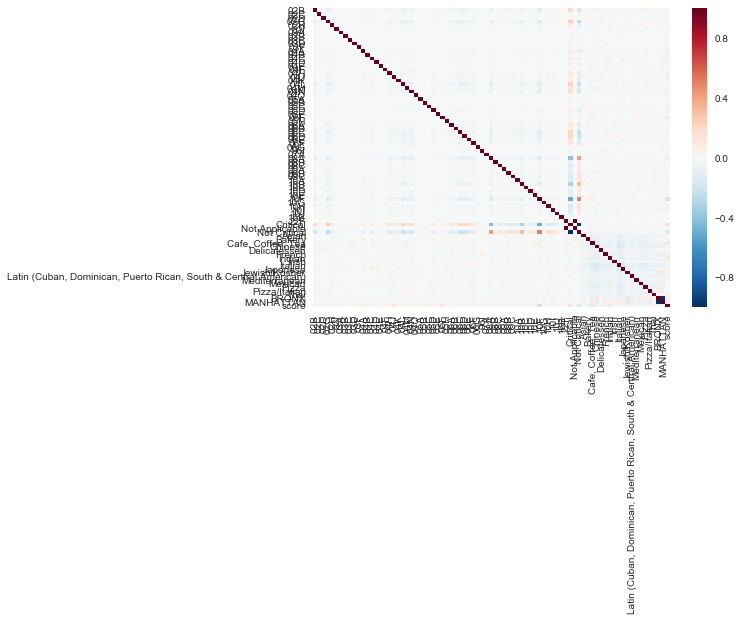

In [20]:
restcorr = restdatafilter.corr()
sns.heatmap(restcorr)

In [21]:
#Isolate feature and target columns

rest_features = restdatafilter.columns.tolist()[0:-2]
rest_features = restdatafilter[rest_features]
rest_features

rest_target = restdatafilter.columns.tolist()[-2]
rest_target = restdatafilter[rest_target]

In [22]:
sc = StandardScaler() #create a scaler object
sc.fit(rest_features) #fit the scaler. calculates means and std of every column
X_scaled = sc.transform(rest_features) #transform the data with it (takes z-score data). Need to store it
#fit_transform does both simultaneously
X_scaled = pd.DataFrame(sc.transform(rest_features),columns=rest_features.columns.tolist()) #keeps columns and converts to dataframe a

In [23]:
#scaler = StandardScaler() #create a scaler object
#scaler.fit(rest_features) #fit the scaler
#X_scaled = scaler.transform(rest_features) #transform the data with it

In [24]:
y = rest_target

In [30]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size=.3,
                                                 random_state=20)

Decision Tree Train/Test RMSE: 12.1789152912   12.9008921701
Decision Tree Train/Test RMSE: 12.0863036902   12.8531101188
Decision Tree Train/Test RMSE: 12.0280927639   12.8109737991
Decision Tree Train/Test RMSE: 11.9682109101   12.7469423228
Decision Tree Train/Test RMSE: 11.923113153   12.7382830805
Decision Tree Train/Test RMSE: 11.8741227623   12.6708506168
Decision Tree Train/Test RMSE: 11.8342673122   12.6698994498
Decision Tree Train/Test RMSE: 11.8056012979   12.6462004645
Decision Tree Train/Test RMSE: 11.7734275388   12.6355152651
Decision Tree Train/Test RMSE: 11.741310939   12.6352183398
Decision Tree Train/Test RMSE: 11.6997416062   12.6216426731
Decision Tree Train/Test RMSE: 11.6648192616   12.6152454067
Decision Tree Train/Test RMSE: 11.63029357   12.6122425262
Decision Tree Train/Test RMSE: 11.5838784688   12.6407150034
Decision Tree Train/Test RMSE: 11.5370246479   12.6396760729
Decision Tree Train/Test RMSE: 11.4907882599   12.6214717667
Decision Tree Train/Test RMS

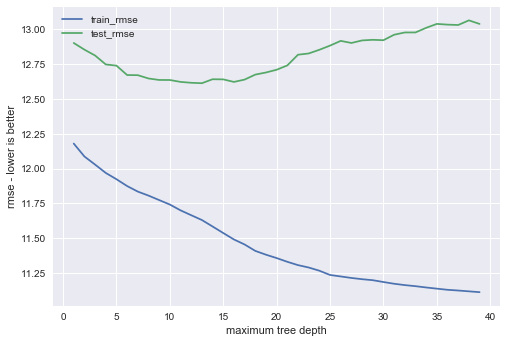

In [31]:
depths = range(1,40)
train_rmse, test_rmse = [],[]
for depth in depths:
    decision_tree = DecisionTreeRegressor(max_depth=depth,random_state=10)
    decision_tree.fit(X_train,y_train)
    curr_train_rmse = np.sqrt(mean_squared_error(y_train,decision_tree.predict(X_train)))
    curr_test_rmse = np.sqrt(mean_squared_error(y_test,decision_tree.predict(X_test)))
    print "Decision Tree Train/Test RMSE:",curr_train_rmse," ",curr_test_rmse
    train_rmse.append(curr_train_rmse)
    test_rmse.append(curr_test_rmse)
sns.plt.plot(depths,train_rmse,label='train_rmse')
sns.plt.plot(depths,test_rmse,label='test_rmse')
sns.plt.xlabel("maximum tree depth")
sns.plt.ylabel("rmse - lower is better")
sns.plt.legend()

Minimum seems to be around tree depth of 10.  Not a very great model with RSME ~13

In [32]:
decision_tree_13 = DecisionTreeRegressor(max_depth=13)
decision_tree_13.fit(X_train,y_train)
print "Decision Tree RMSE:",np.sqrt(
    mean_squared_error(y_test,decision_tree.predict(X_test)))

Decision Tree RMSE: 13.0377006149


In [33]:
#Single Tree
best_single_tree = DecisionTreeRegressor(max_depth=10, random_state=12)
best_single_tree.fit(X_train, y_train)
y_pred_single = best_single_tree.predict(X_test)

#Bag of 500 trees
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=12)
bagreg.fit(X_train, y_train)
y_pred_bag = bagreg.predict(X_test)

#Random forest of 500 trees
rf = RandomForestRegressor(n_estimators=500, bootstrap=True, oob_score=True, random_state=12)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print "Single Tree RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_single))
print "Bag RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_bag))
print "Random Forest RMSE:",np.sqrt(mean_squared_error(y_test,y_pred_rf))

Single Tree RMSE: 12.639343836
Bag RMSE: 12.8862624625
Random Forest RMSE: 12.8867343477


The single tree RSME has slightly better RSME. Random Forrest and Bagging Regressor are about the same. 

In [34]:
#Determine of estimators to use in random forrest

# list of values to try for n_estimators
estimator_range = range(20, 500, 20)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, bootstrap=True, oob_score=True, random_state=1)
    rfreg.fit(X_train,y_train)
    preds = rfreg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    RMSE_scores.append(rmse)

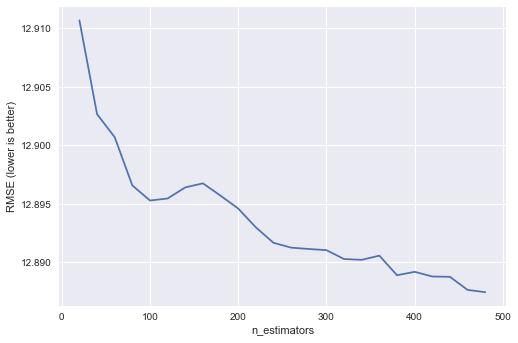

In [35]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
sns.plt.plot(estimator_range, RMSE_scores)
sns.plt.xlabel('n_estimators')
sns.plt.ylabel('RMSE (lower is better)')

In [36]:
# list of values to try for max_features (81 features)
feature_range = range(1, 80+1)

# list to store the average RMSE for each value of max_features
RMSE_scores = []

for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=500, bootstrap=True, 
                                  oob_score=True, max_features=feature, random_state=1234)
    rfreg.fit(X_train,y_train)
    preds = rfreg.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test,preds))
    RMSE_scores.append(rmse)

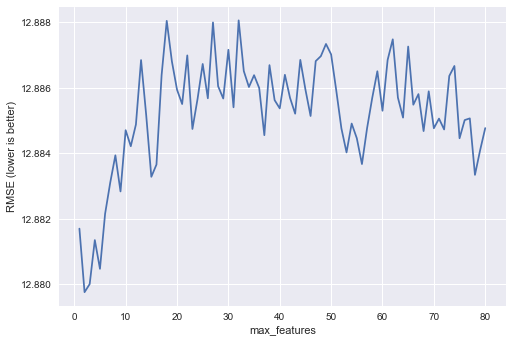

In [80]:
# plot n_estimators (x-axis) versus RMSE (y-axis)
sns.plt.plot(feature_range, RMSE_scores)
sns.plt.xlabel('max_features')
sns.plt.ylabel('RMSE (lower is better)')

RSME looks to be a bit erratic as the # of features increases.  Lowest RSME seems to be around 2-3. However, overall RSME improvement is less than 0.1 as the number of fatures increases. 

In [37]:
#Try reducing features to 3

rfreg_best = RandomForestRegressor(n_estimators=500, max_features=3, bootstrap=True, oob_score=True, random_state=123)
rfreg_best.fit(X_train,y_train)
preds = rfreg_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test,preds))
print "Best RMSE:",rmse

Best RMSE: 12.877563134


In [38]:
rfreg_best.feature_importances_

array([  1.09275544e-02,   1.23007794e-03,   1.03648176e-04,
         1.04407286e-02,   1.12263080e-02,   1.17015686e-03,
         5.01601554e-03,   3.19084288e-04,   6.49724870e-04,
         2.01882152e-04,   0.00000000e+00,   1.42725765e-02,
         6.16333629e-03,   1.06661210e-02,   2.96232906e-03,
         1.72025930e-03,   5.47947008e-05,   1.99629784e-02,
         3.15500069e-02,   3.57911243e-03,   8.91692083e-03,
         8.94174523e-03,   1.20914104e-02,   4.39425463e-03,
         5.16793428e-05,   0.00000000e+00,   8.33578012e-03,
         1.93063866e-02,   2.51840062e-03,   5.12333614e-02,
         8.48766794e-03,   8.29908448e-03,   9.39979646e-03,
         1.76396017e-02,   1.79870302e-02,   1.13306694e-02,
         9.52627603e-03,   1.56765911e-03,   1.36549220e-04,
         3.98170918e-04,   3.53604881e-02,   4.73949218e-03,
         9.24853362e-03,   4.60947956e-03,   4.53624909e-03,
         8.28962703e-03,   6.25249255e-03,   1.38270173e-02,
         2.73469858e-03,

In [39]:
# compute feature importances

rest_feature_names = restdatafilter.ix[:,:-2].columns.tolist()

pd.DataFrame({'feature':rest_feature_names,'importance':rfreg_best.feature_importances_}).sort_values(by='importance',ascending=False)

,feature,importance
51,10F,0.072763
29,05F,0.051233
63,"Cafe, Coffee, Tea",0.042615
67,Indian,0.041262
58,Critical,0.037359
40,08A,0.035360
60,Not Critical,0.034950
18,04J,0.031550
64,Chinese,0.029904
77,Thai,0.029436


Interesting to see certain cuisine indicators were important as to what the output of the model was.

In [44]:
Run decision tree

decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(X_train,y_train)
print "Decision Tree RMSE:",np.sqrt(
    mean_squared_error(y_test,decision_tree.predict(X_test)))

Decision Tree RMSE: 12.8109737991


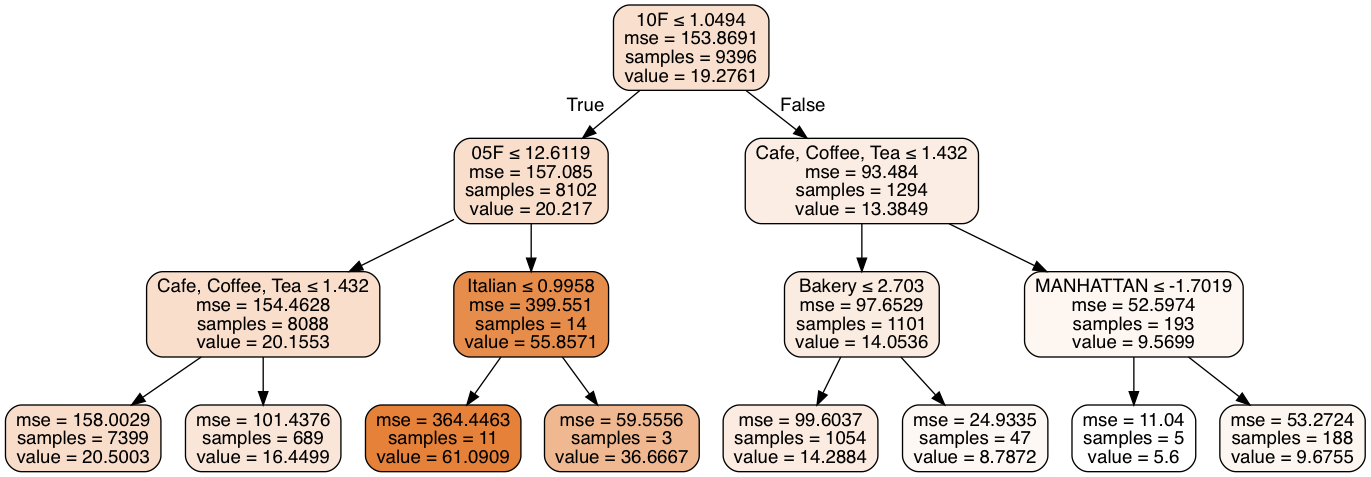

In [45]:

#Plot decision tree
dot_data2 = StringIO()  
export_graphviz(decision_tree, out_file=dot_data2,  
                    feature_names=X_train.columns.tolist(),  
                    filled=True, rounded=True,  
                    special_characters=True)  
graph_best = pydotplus.graph_from_dot_data(dot_data2.getvalue())  
Image(graph_best.create_png())

In [46]:
from sklearn.dummy import DummyClassifier
dumb_model = DummyClassifier(strategy='most_frequent')
dumb_model.fit(X_train, y_train)
y_dumb_class = dumb_model.predict(X_test)
print "Most frequent class dummy classifier test accuracy: ",metrics.accuracy_score(y_test, y_dumb_class)

Most frequent class dummy classifier test accuracy:  0.1045183714
